133008100 DL CSCE 636 Project-1

Instructions to run code

1. Run "preprocess_data" function before running the model on test data. - X_test=preprocess_data(X_test)
2. And then its a direct process. 

Load Training data and labels

In [1]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import pickle
import matplotlib.pyplot as plt

In [2]:
train_data_path="./636_project1_train_images"
train_labels_path="./636_project1_train_labels"

X_train=pickle.load(open(train_data_path, 'rb')) 
y_train=pickle.load(open(train_labels_path, 'rb')) 

Before training, I preprocessed the data by reshaping it into the shape the network
expects and scaling it so that all values are in the [0, 1] interval. The training
images, for instance, were stored in an array of shape (60000, 28, 28) of type
uint8 with values in the [0, 255] interval. We transform it into a float32 array of
shape (60000, 28 * 28) with values between 0 and 1.

In [3]:
def preprocess_data(X_train):
    X_train = X_train.reshape((60000, 28, 28, 1))
    X_train = X_train.astype("float32") / 255
    return X_train

In [4]:
X_train.shape

TensorShape([60000, 28, 28])

In [5]:
y_train.shape

TensorShape([60000])

In [6]:
import numpy as np
set(np.array(y_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

tf.Tensor(6, shape=(), dtype=uint8)


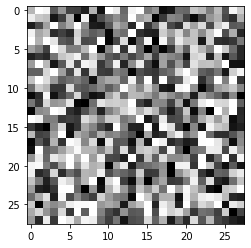

In [7]:
digit = X_train[103]
print(y_train[103])
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [8]:
X_train=preprocess_data(X_train)

In the case of noisy image data, Conv2DTranspose can be used to recover the original image from the noisy image. The layer learns to reverse the effects of noise by learning a mapping from the noisy image to the original image. The deconvolution process helps in removing the noise and enhancing the details in the image.

The Conv2DTranspose layer works by performing a convolution operation on the input with a learned set of filters, followed by a scaling operation to upsample the output to a larger size. The output of the layer is fed into subsequent layers for further processing.

Batch normalization helps in stabilizing the input to each layer of the neural network, making the training process faster and more efficient. It can also help in reducing the effect of noise on the model by normalizing the inputs to each layer.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

def create_model(inputs,outputs):
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
    return model

In [14]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        1849

The kfold.split() method generates indices to split the data into training and test sets for each fold of the cross-validation. The model.fit() method is then used to train the model on training data for each fold again and again.

Using callbacks to act on a model during training for earlystopping and model check point.

In [15]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=4, shuffle=True)



callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath='Final_model_cv_new.h5',
    monitor='val_loss',
    save_best_only=True,
    )
]


for train, test in kfold.split(X_train, y_train): 
    model = create_model(inputs,outputs)
    history = model.fit(X_train[train], 
            y_train[train],
            epochs=20, 
            validation_data=(X_train[test], y_train[test]),
            callbacks=callbacks_list,
            batch_size=256)

Epoch 1/20
176/176 [==============================] - 60s 338ms/step - loss: 2.1158 - accuracy: 0.2295 - val_loss: 2.2621 - val_accuracy: 0.1869
Epoch 2/20
176/176 [==============================] - 58s 331ms/step - loss: 1.7229 - accuracy: 0.3969 - val_loss: 2.0900 - val_accuracy: 0.3043
Epoch 3/20
176/176 [==============================] - 58s 329ms/step - loss: 1.4612 - accuracy: 0.4949 - val_loss: 1.7633 - val_accuracy: 0.4975
Epoch 4/20
176/176 [==============================] - 59s 334ms/step - loss: 1.3507 - accuracy: 0.5370 - val_loss: 1.5119 - val_accuracy: 0.5082
Epoch 5/20
176/176 [==============================] - 58s 331ms/step - loss: 1.2863 - accuracy: 0.5571 - val_loss: 1.2384 - val_accuracy: 0.5874
Epoch 6/20
176/176 [==============================] - 58s 329ms/step - loss: 1.2283 - accuracy: 0.5767 - val_loss: 1.1721 - val_accuracy: 0.5955
Epoch 7/20
176/176 [==============================] - 58s 327ms/step - loss: 1.1885 - accuracy: 0.5942 - val_loss: 1.1375 - val_ac

In [18]:
# model.evaluate(X_test,y_test)